In [135]:
import torch
import torchtext
import gc
import time
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset
from sklearn.metrics import accuracy_score
from datasets import load_dataset
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [136]:
#train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()
data = load_dataset("ag_news")
data.set_format(type="pandas")
label_names = ["World", "Sports", "Business", "Sci/Tech"]

Using custom data configuration default
Reusing dataset ag_news (C:\Users\38599\.cache\huggingface\datasets\ag_news\default\0.0.0\bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


  0%|          | 0/2 [00:00<?, ?it/s]

In [137]:
train = data['train'][:]
test = data['test'][:]
train, valid = train_test_split(train, test_size=0.10, random_state=0)

In [138]:
train

,text,label
40472,World markets - 27 September 2004 New York - T...,2
118774,"States #39; Pocketbooks Are Fuller, but Health...",2
62822,"Greenspan on Oil In a speech on Friday, Alan G...",2
26579,Urgent review over Palace protest A Royal secu...,0
78000,Azeri #39;s got no chance in Breeders #39; Cup...,1
...,...,...
45891,Senate postpones vote on file-swapping bill co...,3
117952,"FedEx Profit Jumps, Outlook Is Raised NEW YOR...",2
42613,More Arrested in Pakistan Following Killing of...,0
43567,PalmSource unveils Cobalt OS PalmSource finall...,3


In [139]:
from torch.utils.data import Dataset
class Dataset(Dataset):
 
    def __init__(self, data):
        self.text = data['text'].values.tolist()
        self.label = data['label'].values.tolist()
 
    def __len__(self):
        return len(self.label)
   
    def __getitem__(self,idx):
        return self.label[idx], self.text[idx]

In [140]:
train_dataset = Dataset(train)
valid_dataset = Dataset(valid)
test_dataset = Dataset(test)

In [141]:
def build_vocabulary(datasets):
    for dataset in datasets:
        for _, text in dataset:
            yield tokenizer(text)

def vectorize_batch(batch):
    Y, X = list(zip(*batch))
    X = [vocab(tokenizer(text)) for text in X]
    X = [tokens + ([0]* (max_words - len(tokens))) if len(tokens) < max_words else tokens[:max_words] for tokens in X] 

    return torch.tensor(X, dtype=torch.int32), torch.tensor(Y)

In [142]:
tokenizer = get_tokenizer("basic_english")
vocab = build_vocab_from_iterator(build_vocabulary([train_dataset, valid_dataset]), min_freq=1, specials=["<UNK>"])
vocab.set_default_index(vocab["<UNK>"])

In [143]:
max_words = 25

train_loader = DataLoader(train_dataset, batch_size=1024, collate_fn=vectorize_batch, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1024, collate_fn=vectorize_batch)
test_loader  = DataLoader(test_dataset , batch_size=1024, collate_fn=vectorize_batch)

In [144]:
from torch import nn
from torch.nn import functional as F

embed_len = 50
hidden_dim = 50
N_layers=1

class RNNClassifier(nn.Module):
    def __init__(self):
        super(RNNClassifier, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_len)
        self.rnn = nn.RNN(input_size=embed_len, hidden_size=hidden_dim, num_layers=N_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, len(label_names))

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        output, hidden = self.rnn(embeddings, torch.randn(N_layers, len(X_batch), hidden_dim))
        return self.linear(output[:,-1])

In [145]:
rnn_classifier = RNNClassifier()

In [146]:
for layer in rnn_classifier.children():
    print("Layer : {}".format(layer))
    print("Parameters : ")
    for param in layer.parameters():
        print(param.shape)
    print()

Layer : Embedding(95811, 50)
Parameters : 
torch.Size([95811, 50])

Layer : RNN(50, 50, batch_first=True)
Parameters : 
torch.Size([50, 50])
torch.Size([50, 50])
torch.Size([50])
torch.Size([50])

Layer : Linear(in_features=50, out_features=4, bias=True)
Parameters : 
torch.Size([4, 50])
torch.Size([4])



In [147]:
def val_loss(model, loss_fn, val_loader):
    with torch.no_grad():
        y_shuffled, y_preds, losses = [],[],[]
        for X, y in val_loader:
            preds = model(X)
            
            loss = loss_fn(preds, y)
            losses.append(loss.item())

            y_shuffled.append(y)
            y_preds.append(preds.argmax(dim=-1))

        y_shuffled = torch.cat(y_shuffled)
        y_preds = torch.cat(y_preds)

        print("val loss : {:.4f}".format(torch.tensor(losses).mean()))


def train_model(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    start_time = time.time()
    for i in range(1, epochs+1):
        print(f"Epoch: {i}")
        losses = []
        for X, y in tqdm(train_loader, desc='Training'):
            y_preds = model(X)
    
            loss = loss_fn(y_preds, y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("train loss: {:.4f}".format(torch.tensor(losses).mean()))
        val_loss(model, loss_fn, val_loader)
    end_time = time.time()
    return end_time - start_time

In [148]:
epochs = 15
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
rnn_classifier = RNNClassifier()
optimizer = Adam(rnn_classifier.parameters(), lr=learning_rate)

train_model(rnn_classifier, loss_fn, optimizer, train_loader, valid_loader, epochs)

Epoch: 1


Training: 100%|██████████████████████████████████████████████████████████████████████| 106/106 [00:16<00:00,  6.52it/s]


train loss: 1.3078
val loss : 1.1584
Epoch: 2


Training: 100%|██████████████████████████████████████████████████████████████████████| 106/106 [00:16<00:00,  6.56it/s]


train loss: 0.9824
val loss : 0.8606
Epoch: 3


Training: 100%|██████████████████████████████████████████████████████████████████████| 106/106 [00:15<00:00,  6.84it/s]


train loss: 0.7489
val loss : 0.7078
Epoch: 4


Training: 100%|██████████████████████████████████████████████████████████████████████| 106/106 [00:15<00:00,  6.72it/s]


train loss: 0.6076
val loss : 0.6012
Epoch: 5


Training: 100%|██████████████████████████████████████████████████████████████████████| 106/106 [00:15<00:00,  6.79it/s]


train loss: 0.5115
val loss : 0.5493
Epoch: 6


Training: 100%|██████████████████████████████████████████████████████████████████████| 106/106 [00:15<00:00,  6.67it/s]


train loss: 0.4505
val loss : 0.5066
Epoch: 7


Training: 100%|██████████████████████████████████████████████████████████████████████| 106/106 [00:16<00:00,  6.62it/s]


train loss: 0.4024
val loss : 0.4853
Epoch: 8


Training: 100%|██████████████████████████████████████████████████████████████████████| 106/106 [00:15<00:00,  6.77it/s]


train loss: 0.3675
val loss : 0.4641
Epoch: 9


Training: 100%|██████████████████████████████████████████████████████████████████████| 106/106 [00:15<00:00,  6.65it/s]


train loss: 0.3403
val loss : 0.4505
Epoch: 10


Training: 100%|██████████████████████████████████████████████████████████████████████| 106/106 [00:15<00:00,  6.81it/s]


train loss: 0.3148
val loss : 0.4353
Epoch: 11


Training: 100%|██████████████████████████████████████████████████████████████████████| 106/106 [00:15<00:00,  6.71it/s]


train loss: 0.2932
val loss : 0.4314
Epoch: 12


Training: 100%|██████████████████████████████████████████████████████████████████████| 106/106 [00:15<00:00,  6.77it/s]


train loss: 0.2768
val loss : 0.4241
Epoch: 13


Training: 100%|██████████████████████████████████████████████████████████████████████| 106/106 [00:15<00:00,  6.66it/s]


train loss: 0.2589
val loss : 0.4199
Epoch: 14


Training: 100%|██████████████████████████████████████████████████████████████████████| 106/106 [00:16<00:00,  6.61it/s]


train loss: 0.2450
val loss : 0.4269
Epoch: 15


Training: 100%|██████████████████████████████████████████████████████████████████████| 106/106 [00:16<00:00,  6.55it/s]


train loss: 0.2307
val loss : 0.4263


250.49429416656494

In [149]:
def predict(model, loader):
    start_time = time.time()
    y_shuffled, y_preds = [], []
    for X, y in loader:
        preds = model(X)
        y_preds.append(preds)
        y_shuffled.append(y)
    gc.collect()
    y_preds, y_shuffled = torch.cat(y_preds), torch.cat(y_shuffled)
    end_time = time.time()
    test_time = end_time - start_time

    return y_shuffled.detach().numpy(), F.softmax(y_preds, dim=-1).argmax(dim=-1).detach().numpy(), test_time

test_true, test_pred, test_time = predict(rnn_classifier, test_loader)

In [150]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

print('classification report')
print(classification_report(test_true, test_pred, target_names=label_names, digits=4))
print(f"Testing time: {test_time}")

classification report
              precision    recall  f1-score   support

       World     0.8750    0.8732    0.8741      1900
      Sports     0.9270    0.9295    0.9283      1900
    Business     0.8299    0.8242    0.8270      1900
    Sci/Tech     0.8347    0.8400    0.8374      1900

    accuracy                         0.8667      7600
   macro avg     0.8667    0.8667    0.8667      7600
weighted avg     0.8667    0.8667    0.8667      7600

Testing time: 0.6605420112609863


In [151]:
def plot_confusion_matrix(y_true, y_preds, labels=None):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".4f", ax=ax, colorbar=False)
    plt.show()

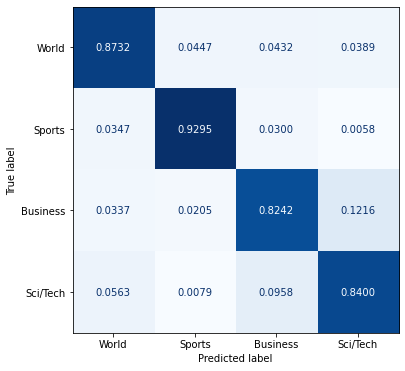

In [152]:
plot_confusion_matrix(test_true, test_pred, labels=label_names)